**Import Dependencies**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dropout, Dense
from keras import Sequential
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

**Data Collection and Preprocessing**

In [28]:
# Load dataset from csv to DataFrame
df = pd.read_csv('/content/train.csv', engine='python',error_bad_lines=False)

Skipping line 3074: unexpected end of data


In [29]:
# First 5 rows od DataFrame
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [30]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [31]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3072 non-null   int64 
 1   title   2987 non-null   object
 2   author  2769 non-null   object
 3   text    3065 non-null   object
 4   label   3072 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 120.1+ KB


In [33]:
# Drop unnecessary columns
df = df.drop(columns=['id', 'title', 'author'], axis=1)

In [34]:
# Drop null values
df.dropna(axis=0)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
...,...,...
3067,Obama's UN Ambassador: Cuba is Right About Our...,1
3068,i can hear msm somewhere using this as proof r...,1
3069,This morning’s key headlines from Generational...,0
3070,This morning’s key headlines from Generational...,0


In [35]:
len(df)

3072

In [36]:
# Lowercase the data
df['clean_news'] = df['text'].str.lower()
df['clean_news']

0       house dem aide: we didn’t even see comey’s let...
1       ever get the feeling your life circles the rou...
2       why the truth might get you fired october 29, ...
3       videos 15 civilians killed in single us airstr...
4       print \nan iranian woman has been sentenced to...
                              ...                        
3067    obama's un ambassador: cuba is right about our...
3068    i can hear msm somewhere using this as proof r...
3069    this morning’s key headlines from generational...
3070    this morning’s key headlines from generational...
3071    politics the eu’s nemtsov forum is a phoney, p...
Name: clean_news, Length: 3072, dtype: object

In [37]:
# Remove special characters and punctuations
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ')
df['clean_news']

0       house dem aide we didnt even see comeys letter...
1       ever get the feeling your life circles the rou...
2       why the truth might get you fired october 29 2...
3       videos 15 civilians killed in single us airstr...
4       print an iranian woman has been sentenced to s...
                              ...                        
3067    obamas un ambassador cuba is right about our h...
3068    i can hear msm somewhere using this as proof r...
3069    this mornings key headlines from generationald...
3070    this mornings key headlines from generationald...
3071    politics the eus nemtsov forum is a phoney pol...
Name: clean_news, Length: 3072, dtype: object

In [38]:
# Remove stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: " ".join([word for word in str(x).split() if word not in stop]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


**Data Analysis**

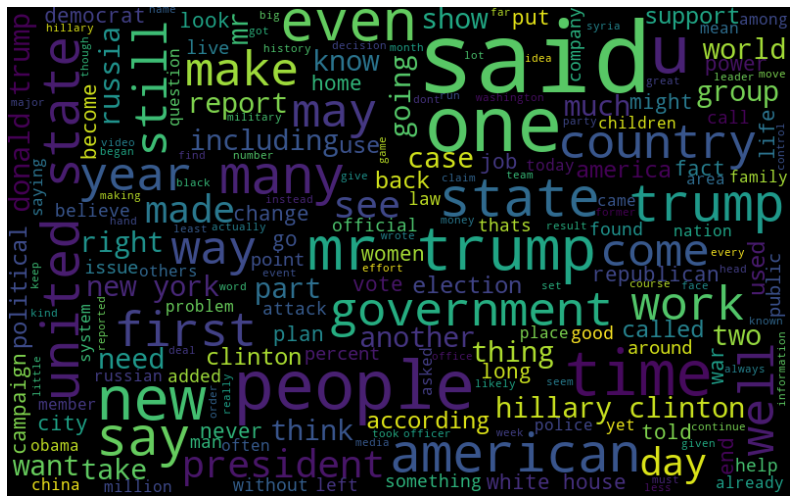

In [39]:
# Visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_news']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

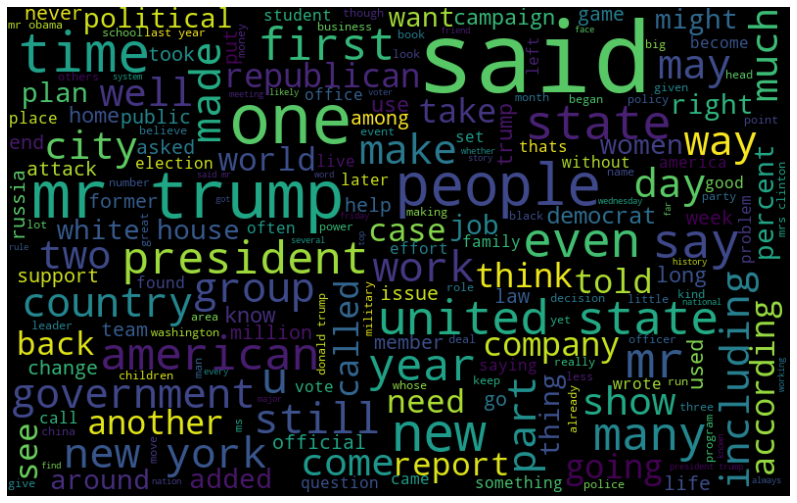

In [40]:
# Visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

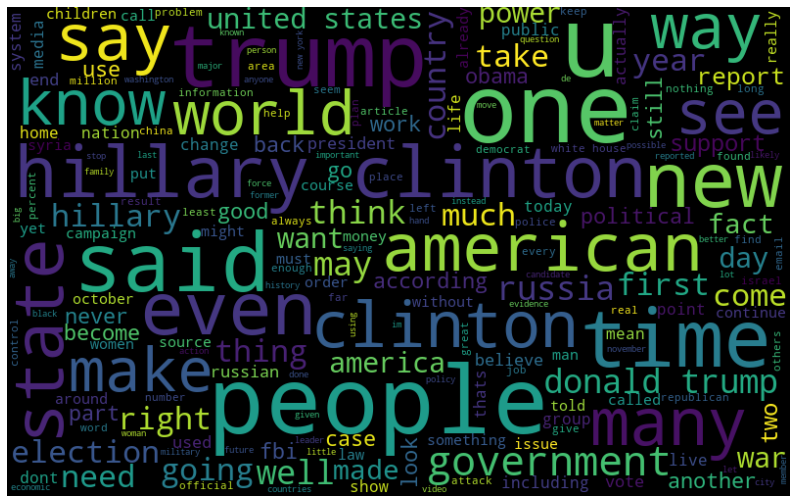

In [41]:
# Visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Create Word Embeddings**

In [57]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size 

71665

In [58]:
# Padding data
sequences = tokenizer.texts_to_sequences(df['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')


In [76]:
# Create embedding index
embedding_index = {}
with open('/content/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='object')
    embedding_index[word] = coefs

In [77]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

**Input Split**

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_seq, df['label'], test_size=0.20, random_state=42, stratify=df['label'])

**Model Training**

In [79]:
model = Sequential([
    Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.2),
    Dense(512),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
])

In [80]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         7166600   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

In [88]:
# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/20
77/77 [==============================] - 4s 55ms/step - loss: 0.6509 - accuracy: 0.6011 - val_loss: 0.6943 - val_accuracy: 0.4959
Epoch 2/20
77/77 [==============================] - 4s 53ms/step - loss: 0.6920 - accuracy: 0.5226 - val_loss: 0.6880 - val_accuracy: 0.4959
Epoch 3/20
77/77 [==============================] - 4s 57ms/step - loss: 0.6862 - accuracy: 0.5401 - val_loss: 0.6741 - val_accuracy: 0.6081
Epoch 4/20
77/77 [==============================] - 4s 54ms/step - loss: 0.6569 - accuracy: 0.6007 - val_loss: 0.6677 - val_accuracy: 0.4959
Epoch 5/20
77/77 [==============================] - 4s 53ms/step - loss: 0.6461 - accuracy: 0.6182 - val_loss: 0.5659 - val_accuracy: 0.6813
Epoch 6/20
77/77 [==============================] - 4s 54ms/step - loss: 0.6035 - accuracy: 0.6854 - val_loss: 0.5390 - val_accuracy: 0.7398
Epoch 7/20
77/77 [==============================] - 4s 55ms/step - loss: 0.4566 - accuracy: 0.7867 - val_loss: 0.3854 - val_accuracy: 0.8325
Epoch 8/20
77

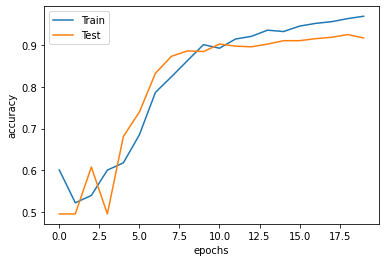

In [89]:
 # Visualize the accuracy
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.xlabel('epochs')
 plt.ylabel('accuracy')
 plt.legend(['Train', 'Test'])
 plt.show()

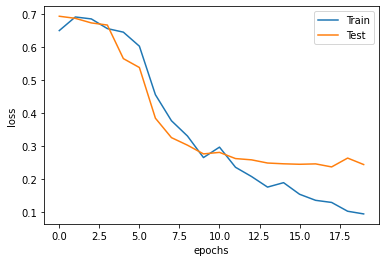

In [90]:
  # Visualize the loss
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.xlabel('epochs')
 plt.ylabel('loss')
 plt.legend(['Train', 'Test'])
 plt.show()